# ![](../graphics/stat_ai_logo.png)
***
# Machine Learning with Structured Patient Data

In this module, we will work through an illustrated example of using artificial intelligence to develop a patient risk prediction tool using electronic health records (EHR) data. *Adapted from Parisa Rashidi 2021, University of Florida Biomedical Data Science, Department of Biomedical Engineering.*

### After this module, students will be able to:

* Explain the lifecycle of typical machine learning (ML) projects.
* Preprocess datasets using Pandas implementations of common data pipelines.
* Train an XGBoost machine learning model using a structured patient dataset.
* Build a deep learning (DL) classifier using Keras.
* Explain model decision-making through interpretability techniques.

In this notebook, we will implement two machine learning models to predict the risk of acute kidney injury (AKI) following major inpatient surgery, using a tabular dataset of patient features.

# ![](../graphics/get_started_icon.png)

### Motivation

* Predicting surgical complications *before* surgery can inform (1) shared decisions regarding the appropriateness of procedures, (2) targeted risk-reduction strategies, and (3) postoperative resource use. 

* Cognitive and judgment errors are major sources of potentially preventable complications.
    * Example: if the risk of complications is underestimated, high-risk patients may be triaged to general wards rather than more appropriate intensive care units (ICUs).
    
* AI-based clinical decision support has the potential to mitigate harm from cognitive errors occurring when estimating the risk of postoperative complications.

* All patients have a unique risk profile that is specific to their demographic characteristics, comorbid conditions, physiological reserve, planned surgical procedure, and surgeon skill.

* Clinicians sometimes display moderate ability to estimate risk probabilities. AI tools are intended to augment decision-making.

* Many clinicians are hindered by time-consuming manual data entry requirements and lack of integration with clinical workflow.
    
* AI predictive models using automated EHR data inputs may be able to mitigate these challenges.

### Lifecycle of ML

Shown below are the major steps that are involved in a typical ML lifecycle.
<center><img src="../graphics/ml.png" alt="ML lifecycle" width="50%"></center>

#### 1. Data extraction and processing
* Relevant data must be extracted (example: all revelant laboratory values and vital signs).
* Data quality and conformation to modeling requirements must be ensured through data preprocessing (example: fixing the missing data, removing any unwanted outliers, and encoding the categorical data.)

#### 2. Model development
* Machine learning models are built from data.
* Recall our module on functions: an ML model can be thought of as a **function** that maps a set of input values (example: patient characteristics) to an output value (example: probability of developing AKI).
* We develop a model on data from a **training** cohort.
* During the model refinement stage, known as **training**, model parameters (such as *weights* and *biases*) are altered to optimize the associations between inputs and outputs.
* After training, a model is ready to make predictions on *new data it has not seen before*. But how accurate will it be?

#### 3. Evaluation and Intepretation
* Once a ML model is trained, we evaluate the end result on **testing** dataset to see how well the model performed or how reliable it is.
* Multiple performance metrics such as accuracy, AUC, sensitivity, and specificity can be evaluated.
* Once we are satisfied with a model's performance, we may implement **explainable AI (XAI)** techniques to discover **why** a model behaves in a particular way.
* XAI techniques include computing a relative importance score associated with each input feature/column (for a given patient, how important was each input in determining that patient's prediction?).

#### 4. Deployment
* ML model deployment is the process of placing a finished ML model into a live environment, such as creating a web service or mobile application for prediction.
* It is imperative that the performance of an established model is continually monitored in prospective deployment to safeguard against data distribution shifts resulting from changes in populations, practice, or other changes that may result in deteriorating model performance over time.

#### 5. Optimization
* A deployed ML model has real-world impact and must be continuously monitored and maintained.
* When new or updated data becomes available, or when we determine that an existing deployed model no longer results in satisfactory performance, we need to optimize the model by re-training and re-evaluating the ML model.

In this notebook, we will only focus on the first three phases. 

## Data and problem definition

We will be using an EHR dataset containing 10,000 surgical patients.
* **Input features (X)** (47)
    * Demographic variables
    * Admission and surgery information
    * Social determinants of health (SDOH)
    * One-year medication history
    * Admission comorbidities
    * Estimated glomerular filtration rate (eGFR: measures kidney function) before surgery
* **Outcome (Y)** (1)
    * Postoperative AKI: onset of acute kidney injury (AKI) at any point between the end of surgery and patient discharge or death.
    * This is a binary outcome (it is recorded as either 0 or 1 for each patient). The ML model will learn to predict the risk of each patient developing AKI based on the specific input features.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://www.dropbox.com/s/ol9cs1sjsr2yhal/data_small.csv?dl=1')
df.head()

,patient_id,sex,ethnicity,race,language,marital_status,age,bmi,admission_source,emergent,...,valve,coag,obese,wghtloss,lytes,anemia,alc_drug,depress,egfr,aki_surg_disch
0,4757,FEMALE,NON-HISPANIC,WHITE,ENGLISH,SINGLE,43.3690,40.6750,TRANSFER,NON-EMERGENCY,...,0,1,1,1,0,0,0,0,62.8876,0
1,2656,FEMALE,NON-HISPANIC,WHITE,ENGLISH,SINGLE,41.7882,51.3062,NON-TRANSFER,NON-EMERGENCY,...,0,0,0,0,0,0,0,0,81.3574,1
2,9944,FEMALE,NON-HISPANIC,WHITE,ENGLISH,SINGLE,35.8761,26.2132,NON-TRANSFER,NON-EMERGENCY,...,0,0,1,0,0,0,0,0,90.1036,0
3,2065,FEMALE,NON-HISPANIC,AA,ENGLISH,DIVORCED,81.8270,35.5527,NON-TRANSFER,NON-EMERGENCY,...,1,0,1,0,0,0,0,0,28.6199,1
4,1589,FEMALE,NON-HISPANIC,WHITE,ENGLISH,SINGLE,73.6769,39.5073,NON-TRANSFER,NON-EMERGENCY,...,0,0,0,0,0,1,0,1,NaN,0


> As an exploratory step, let's take a look at the distribution of our AKI outcome (how prevalent is postoperative AKI?). We'll use the `value_counts` function we saw before to help answer this question.

In [2]:
# The normalize=True parameter divides each count by the total number of samples.
df['aki_surg_disch'].value_counts(normalize=True)

0    0.8364
1    0.1636
Name: aki_surg_disch, dtype: float64

> We can see from the above that about 16% of the surgical encounters resulted in acute kidney injury.

## Data preprocessing

Before we use our data to train a machine learning model, we must transform the raw data into **features** that an ML model can understand (sometimes these look quite similar, but not always). This critical step is called **data preprocessing**. Since real-world data can be messy, during this phase we also *clean* data to ensure the ML model can learn meaningful patterns.

Common data preprocessing steps may include the following (depending on the ML model used):
* Removing outliers*
* Addressing data missingess
* Transforming binary string columns (e.g., sex) into a numerical form that the model can understand.
* Transforming many-valued string columns (e.g., race) into a numerical form.
* Normalizing input features to give them equal weighting.

\*One common approach to remove outliers in ML projects is to remove observations that fall outside a specified range. In this tutorial, we remove observations whose values are less than the 1st percentile or greater than the 99th percentile.


### Addressing missing data

* Missing data are common in routinely collected health data
    * Many times, missingness can be informative (e.g. a particular test was not ordered because patient was healthy).
    * In other cases, missingness may be at random or due to other factors (e.g., lack of routine follow-up)
* Some models **require** filling in missing data with imputation methods. Others will gladly accept missing data. The decision of when, and how, to impute missing data is often dependent on the model, data, and problem. 
* In a Pandas DataFrame, missing values will be represented by `NaN` (*"Not a Number"*)

One simple, but effective, imputation approach is to replace a patient's missing variable value with a value computed from all other patients. For example, if a patient is missing the `bmi` variable, we might impute the mean value for the `bmi` feature across all other patients. (Recall our Pandas module for other choices!)

# ![](../graphics/example_icon.png)
Let's use code to replace any missing `bmi` values with the `median` bmi from all other patients. We can accomplish this using some Pandas functions we've already seen, along with the `df.fillna(x)` function, which for a given DataFrame `df`, replaces any missing values with the input value `x`.

In [3]:
# We can use Pandas filtering to see examples of where bmi is missing. (Notice the NaN)
df[pd.isnull(df['bmi'])].head()

,patient_id,sex,ethnicity,race,language,marital_status,age,bmi,admission_source,emergent,...,valve,coag,obese,wghtloss,lytes,anemia,alc_drug,depress,egfr,aki_surg_disch
30,1803,FEMALE,NON-HISPANIC,WHITE,ENGLISH,DIVORCED,60.0373,NaN,NON-TRANSFER,EMERGENCY,...,0,0,0,0,0,0,0,0,88.1871,0
48,2050,MALE,HISPANIC,WHITE,ENGLISH,SINGLE,61.8499,NaN,TRANSFER,NON-EMERGENCY,...,0,0,0,0,1,0,0,0,NaN,1
52,5685,MALE,NON-HISPANIC,WHITE,ENGLISH,SINGLE,48.5185,NaN,NON-TRANSFER,NON-EMERGENCY,...,0,0,1,0,0,0,0,0,NaN,0
59,324,MALE,NON-HISPANIC,WHITE,ENGLISH,MARRIED,29.6097,NaN,NON-TRANSFER,NON-EMERGENCY,...,1,0,1,0,0,0,0,0,NaN,0
83,786,FEMALE,NON-HISPANIC,WHITE,ENGLISH,DIVORCED,46.2311,NaN,NON-TRANSFER,NON-EMERGENCY,...,0,0,0,0,1,0,0,0,87.5409,1


In [4]:
# Compute the median BMI (note: missing values are ignored in this calculation)
bmi_median = df['bmi'].median()
print(bmi_median)

29.3395


In [5]:
# Use fillna to replace any missing BMI values with the median BMI value.
df['bmi'] = df['bmi'].fillna(bmi_median)

In [6]:
# Let's re-run this code to see where BMI is still missing
df[pd.isnull(df['bmi'])]

,patient_id,sex,ethnicity,race,language,marital_status,age,bmi,admission_source,emergent,...,valve,coag,obese,wghtloss,lytes,anemia,alc_drug,depress,egfr,aki_surg_disch


BMI is no longer missing! Every patient now has a BMI value for passing into the model.

# ![](../graphics/note_icon.png) 
> There are many alternative approaches for missing data imputation, including k-Nearest neighbors (KNN) and multiple imputation by chained equation (MICE).

### Data Transformation
In general, machine learning models are great at learning from **numerical** data (e.g., 0, 1, 0.5) . However, many important clinical characteristics are stored as **categorical** data (e.g., 'MALE', 'DIVORCED'). For many models, we must convert the categorical values to numerical features through a **data transformation** process.

For categorical variables with **only two** options, we can assign one of the options to be **0**, and the other to be **1**.

Let's see an example of how we would do this for the `sex` variable, which in our particular dataset contains only two values: `MALE` and `FEMALE`:

In [7]:
# Show the unique values of the sex variable before transformation
print(df['sex'].unique())

# We can use the replace function to convert strings to binary numbers
df['sex'] = df['sex'].replace({'FEMALE' : 0, 'MALE' : 1})

# Show the unique values of the sex variable after transformation
print(df['sex'].unique())

['FEMALE' 'MALE']
[0 1]


Great! But what if our categorical variable contains more than two unique values?
* One option would be to replace them with more numbers (for example: 0, 1, 2, 3, ...)
* However, doing this may confuse some models due to implicit ordering and hierarchies
    * If 0=apple, 1=banana, 2=pear, 3=tomato, then does a tomato equal three bananas? Is a pear worth more than a banana which is worth more than an apple? 

One solution is called **one-hot encoding**:
1. For a single categorical variable (e.g., `marital_status`), create a separate column in the dataset for each category of a categorical variable.
    * If there are 4 options, then we create 4 new columns.
2. The values of these columns are zero **except for** the column corresponding to the original value.

Let's see this in action:

In [8]:
# Show the first 5 values of marital_status before one-hot encoding
print(df['marital_status'].head())

# Use the get_dummies() function to perform one-hot encoding on the marital_status column.
marital_status_transformed = pd.get_dummies(df['marital_status'])

# Show the first 5 values of marital_status after one-hot encoding
print(marital_status_transformed.head())

0      SINGLE
1      SINGLE
2      SINGLE
3    DIVORCED
4      SINGLE
Name: marital_status, dtype: object
   DIVORCED  MARRIED  MISSING  SINGLE
0         0        0        0       1
1         0        0        0       1
2         0        0        0       1
3         1        0        0       0
4         0        0        0       1


### Let's skip ahead.
Data analysis, imputation, transformation, and preprocessing take a large portion of any AI/ML project. We only covered a few steps of the process.

🕑 In in the interest of time, let's load a new dataset that has already been preprocessed.

In [9]:
df = pd.read_csv('https://www.dropbox.com/s/smxqzfipqc7bznf/data_small_processed.csv?dl=1')
df.head()

,patient_id,sex,ethnicity,race,language,marital_status,age,bmi,admission_source,emergent,...,valve,coag,obese,wghtloss,lytes,anemia,alc_drug,depress,egfr,aki_surg_disch
0,8028,-0.774396,0.280999,-1.761337,2.041703,-0.142593,0.681428,-0.306080,-0.131796,0.444606,...,-1.426796,0.095069,0.201282,1.528879,0.520542,-0.333964,0.307017,0.639043,0.401557,0
1,2137,-0.891309,-0.588060,-1.434109,-0.870289,0.881813,-1.528051,-0.220767,-1.635882,-2.385601,...,0.240929,2.657194,0.428401,0.293965,-0.208414,0.902814,-0.432256,-1.643186,-1.679018,0
2,9976,0.708010,-1.135709,1.902568,-0.887270,-0.151637,-0.388248,0.907607,0.408247,-0.800785,...,0.387357,-0.269944,-1.101854,-0.738324,-0.154997,0.058208,1.137801,-1.117425,1.998936,0
3,4709,-0.315597,-0.228130,2.225537,0.724888,-0.125359,1.033135,0.919918,0.103634,0.313834,...,1.639858,0.582729,2.035244,-0.201218,-0.181364,-0.412679,0.234088,0.121205,-0.255220,0
4,9903,-0.593951,-2.255714,0.921554,2.476165,-0.865779,2.163047,1.544717,0.809176,0.096506,...,0.581659,0.998988,-0.746183,0.623479,-0.575879,-1.581712,0.281210,-0.326369,0.530276,0


## Model development

It's now time to train our first machine learning models!

We're going to look at two different models to predict postoperative AKI from our patient characteristics contained in `df`:
* **XGBoost:** A popular tree-based model that is known to work well with tabular datasets like ours.
* **Multi-layer perceptron (MLP):** A simple artificial neural network (ANN) model. This model is considered to be one of the simplest forms of **deep learning (DL)**.

### Splitting the dataset

* **Recall** that ML models adjust their internal parameters by feeding in many examples of inputs $X$ and corresponding output $y$. This is called the **training** process. With enough time and training examples, the model can learn associations between inputs and outputs that can help it make a prediction on new data it hasn't ever seen before.

* To evaluate how good our ML model is, we will **test** it on a set of examples that it has never seen before (known as the **test set**), and for each patient in the test set, compare the model's predicted outcome $\hat{y}$ with the true patient outcome $y$.

* With enough testing examples, we can calculate performance metrics such as accuracy and other diagnostic metrics like AUC, sensitivity, and specificity.

Let's take our dataset and prepare it for building our ML model by doing a few final preprocessing items:
* Convert the pandas DataFrame into two NumPy arrays: `X` (inputs) and `y` (AKI outcome)
* Split X and y into training and testing sets. We'll have four variables after this step:
    * `X_train` and `y_train`: the training set
    * `X_test` and `y_test`: the testing set
    * We'll arbitrarily use 20% of the dataset for testing.

#### ![](../graphics/note_icon.png)
> Some of this code may seem unfamiliar to you. That's OK! Follow along with the comments to understand each step.

In [10]:
from sklearn.model_selection import train_test_split # We'll use this function to create the training and testing sets

# Build X (an array/matrix) by taking the values from the entire df DataFrame EXCEPT FOR the first (patient id) and last (AKI outcome) columns
X = df.iloc[:, 1:-1].values

# Build y (a one-dimensional array) by taking only the final column ('aki_surg_disch'). The order of these outcomes exactly matches the order of the rows in X.
y = df.iloc[:, -1].values

# Split X and y into training and testing sets, by using a random 20% of the dataset for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## Creating an XGBoost Model

* Let's train our first XGBoost model to predict postoperative AKI from our patient features.
* We're going to use the popular Python library `xgboost`, which makes it very easy to train an ML model ***in a single line of code!***

In [11]:
import xgboost as xgb

# Create our XGBoost prediction model and assign it to variable xgb
xgb = xgb.XGBClassifier()

# Train the model using the training dataset
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

That was easy! But is this model any good?

To evaluate the performance of our model, we need to compare two quantities:  
* $y$, the true outcomes of our testing set patients. In our code, we'll call this list `y_true`.
* $\hat{y}$, our model's **predicted** outcomes for the testing set patients. We'll call this `y_pred` (predicted).

The XGBoost model has an easy function called `score` that computes the accuracy on a test dataset.

In [12]:
# This will show our model's accuracy on the test set.
xgb.score(X_test, y_test)

0.829

### Feature importance
* We now have our trained XGBoost model, and know how accurate it is at making predictions, but we don't understand **why** it predicts certain outcomes for certain patients.
* For this, we need to turn to the field of **explainable AI (XAI)**, an emerging and active field of AI research.
* In this module, we'll examine one of the simplest forms of explainability, which looks at the model's weight it assigns to each feature.
* Every XGBoost model has a built-in *attribute* variable for this: `feature_importances_` (for convenience, we'll reassign the feature importances to a variable `F`).

In [13]:
# Compute feature importances
F = xgb.feature_importances_

# Take a look at the feature importances.
# The scores are in the order of the columns of our input data.
print(F)

[0.02006534 0.0227169  0.01801753 0.02362856 0.0168312  0.0192095
 0.02053335 0.02513116 0.02204197 0.02237717 0.01894541 0.02156862
 0.02656651 0.01853822 0.01974279 0.01912974 0.02196527 0.01917675
 0.02168204 0.02008043 0.02251171 0.0208749  0.02169918 0.02325575
 0.02268388 0.02035919 0.02334738 0.01918193 0.01700873 0.02299177
 0.0197109  0.02252468 0.02092659 0.01946699 0.02139581 0.02546264
 0.02221232 0.02160385 0.02234855 0.02004287 0.0221352  0.02220558
 0.02131373 0.02628263 0.02159233 0.01999652 0.01891599]


* To make this more informative, we can map these scores to their original feature names and generate a plot to visually compare the importance of each feature.
* Let's do this for the model's top 10 features.

#### ![](../graphics/note_icon.png)
> Some of this code will be new. It's OK to just follow along!

<Axes: ylabel='feature'>

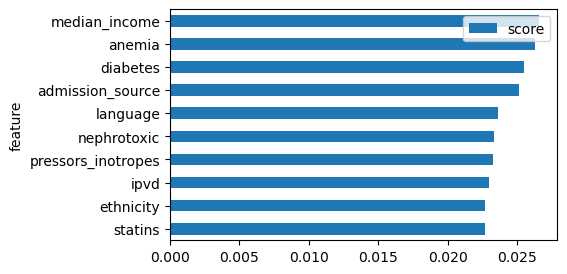

In [14]:
F_df = pd.DataFrame({'feature': df.columns.tolist()[1:-1], 'score': F}).sort_values(by='score').tail(10)
F_df.plot.barh(x='feature', y='score', figsize=(5,3))

* By examining the model's learned weights, we can see that the most influential input was the `surgery_type` feature (further analysis can reveal which surgery types were most predictive of AKI)
* The second most important feature was `lytes`, a comorbidity indicating fluid and electrolyte disorders.